In [16]:
import torch
import torch.nn.functional as F
import math
import cv2
import matplotlib.pyplot as plt

class ViewTransformer:
    def __init__(self,
                 cart_shape,    # (H_cart, W_cart)
                 rv_shape,      # (H_rv, W_rv)
                 range_x, range_y, range_z,
                 range_r, range_phi, range_theta=None):
        # 해상도 파라미터
        self.H_cart, self.W_cart = cart_shape
        self.H_rv,   self.W_rv   = rv_shape

        # Cartesian 범위
        self.x_min, self.x_max = range_x
        self.y_min, self.y_max = range_y

        # Range View 범위 (라디안 변환)
        self.r_min, self.r_max = range_r
        phi_min, phi_max       = range_phi
        self.phi_min = math.radians(phi_min)
        self.phi_max = math.radians(phi_max)

        # 그리드 캐시 (device별 저장)
        self._grid_cart2rv = {}
        self._grid_rv2cart = {}

    def _build_cart2range_grid(self, device):
        """
        Cartesian->Range View: output grid shape = (1, H_rv, W_rv, 2)
        """
        if device not in self._grid_cart2rv:
            # Range 뷰 픽셀 (h, w) -> (r, phi)
            phi_vals = torch.linspace(self.phi_min, self.phi_max, self.W_rv, device=device)
            r_vals   = torch.linspace(self.r_min,    self.r_max,    self.H_rv, device=device)
            r_grid, phi_grid = torch.meshgrid(r_vals, phi_vals)  # shapes (H_rv, W_rv)

            # (r, phi) -> (x, y)
            x = r_grid * torch.cos(phi_grid)
            y = r_grid * torch.sin(phi_grid)

            # (x, y) -> normalized Cartesian coords [-1, 1]
            j = (x - self.x_min) / (self.x_max - self.x_min) * 2.0 - 1.0
            i = (y - self.y_min) / (self.y_max - self.y_min) * 2.0 - 1.0

            grid = torch.stack((j, i), dim=-1)        # (H_rv, W_rv, 2)
            self._grid_cart2rv[device] = grid.unsqueeze(0)  # (1, H_rv, W_rv, 2)
        return self._grid_cart2rv[device]

    def _build_range2cart_grid(self, device):
        """
        Range View->Cartesian: output grid shape = (1, H_cart, W_cart, 2)
        """
        if device not in self._grid_rv2cart:
            # Cartesian 픽셀 coords -> (x, y)
            xs = torch.linspace(
                self.x_min + (self.x_max - self.x_min) / (2 * self.W_cart),
                self.x_max - (self.x_max - self.x_min) / (2 * self.W_cart),
                self.W_cart, device=device
            )
            ys = torch.linspace(
                self.y_min + (self.y_max - self.y_min) / (2 * self.H_cart),
                self.y_max - (self.y_max - self.y_min) / (2 * self.H_cart),
                self.H_cart, device=device
            )
            yv, xv = torch.meshgrid(ys, xs)  # shapes (H_cart, W_cart)

            # (x, y) -> (r, phi)
            r   = torch.sqrt(xv**2 + yv**2)
            phi = torch.atan2(yv, xv)

            # (r, phi) -> normalized Range coords [-1, 1]
            u = (phi - self.phi_min) / (self.phi_max - self.phi_min) * 2.0 - 1.0
            v = (r   - self.r_min  ) / (self.r_max   - self.r_min  ) * 2.0 - 1.0

            grid = torch.stack((u, v), dim=-1)       # (H_cart, W_cart, 2)
            self._grid_rv2cart[device] = grid.unsqueeze(0)  # (1, H_cart, W_cart, 2)
        return self._grid_rv2cart[device]

    def cart2range(self, cart_feat):
        """
        cart_feat: (BS, C, H_cart, W_cart) -> (BS, C, H_rv, W_rv)
        """
        BS, C, H, W = cart_feat.shape
        assert (H, W) == (self.H_cart, self.W_cart), \
            f"Cart shape must be {self.H_cart}×{self.W_cart}, got {H}×{W}"
        device = cart_feat.device

        grid = self._build_cart2range_grid(device).expand(BS, -1, -1, -1)
        return F.grid_sample(
            cart_feat, grid,
            mode='bilinear',
            padding_mode='zeros',
            align_corners=True
        )

    def range2cart(self, range_feat):
        """
        range_feat: (BS, C, H_rv, W_rv) -> (BS, C, H_cart, W_cart)
        """
        BS, C, H, W = range_feat.shape
        assert (H, W) == (self.H_rv, self.W_rv), \
            f"Range shape must be {self.H_rv}×{self.W_rv}, got {H}×{W}"
        device = range_feat.device

        grid = self._build_range2cart_grid(device).expand(BS, -1, -1, -1)
        return F.grid_sample(
            range_feat, grid,
            mode='bilinear',
            padding_mode='zeros',
            align_corners=True
        )


In [17]:
vt = ViewTransformer(
    cart_shape=(256,256),
    rv_shape=(32,1024),
    range_x=(-50.0,50.0), range_y=(-50.0,50.0), range_z=(-4.0,2.0),
    range_r=(0,50),       range_phi=(-180,180), range_theta=(-25,3)
)


torch.Size([1, 3, 256, 256])


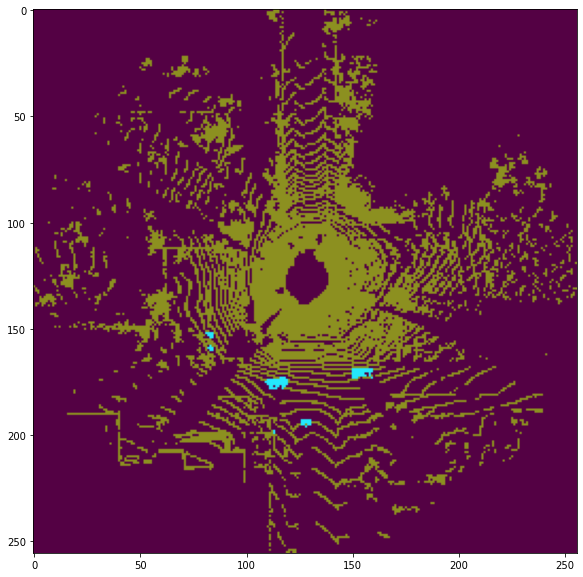

In [18]:
cart_feat = cv2.imread("/home/workspace/work/GNU_MOS/images/descartes.png")
cart_feat = torch.from_numpy(cart_feat).permute(2,0,1).unsqueeze(0).float() / 255.0

print(cart_feat.shape)
plt.figure(figsize=(10,10))
plt.imshow(cart_feat[0].permute(1,2,0).cpu().numpy())

torch.Size([1, 3, 32, 1024])


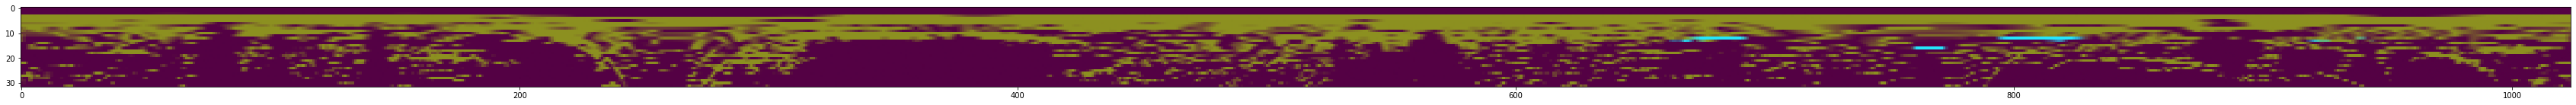

In [21]:
# Cartesian → Range
range_feat = vt.cart2range(cart_feat)

print(range_feat.shape)
plt.figure(figsize=(60,20))
plt.imshow(range_feat[0].permute(1,2,0).cpu().numpy())

torch.Size([1, 3, 256, 256])


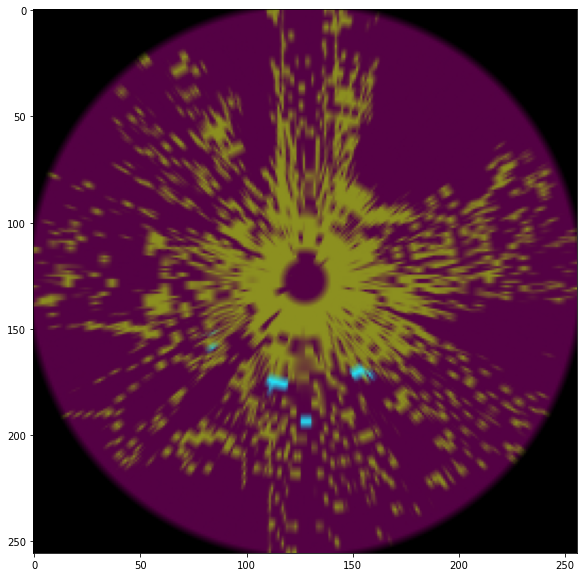

In [22]:
# Range → Cartesian
cart_feat  = vt.range2cart(range_feat) 

print(cart_feat.shape)

plt.figure(figsize=(10,10))
plt.imshow(cart_feat[0].permute(1,2,0).cpu().numpy())